<a href="https://colab.research.google.com/github/pranaychowdary765/-All-Stocks-5-Year-/blob/main/Dataset_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using symbol: AAPL, price column: close
| Model          |   RMSE |   MAE | MAPE   | Directional Acc.   | Notes                                           |
|----------------|--------|-------|--------|--------------------|-------------------------------------------------|
| LSTM(64), L=60 |  3.406 | 2.646 | 1.67%  | 48.12%             | ~16961 params; 80/20 split; scaler fit on train |
| Model         |   RMSE |    MAE | MAPE   | Directional Acc.   | Notes                                           |
|---------------|--------|--------|--------|--------------------|-------------------------------------------------|
| GRU(64), L=60 | 2.3173 | 1.6467 | 1.04%  | 50.63%             | ~12929 params; 80/20 split; scaler fit on train |
| Model              |    RMSE |     MAE | MAPE   | Directional Acc.   | Notes                                                |
|--------------------|---------|---------|--------|--------------------|------------------------------------------------------|
| Random

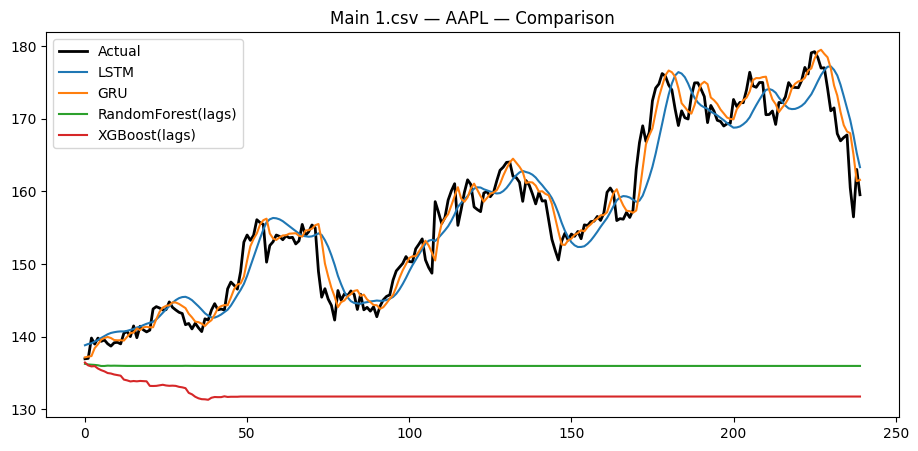


=== Summary (sorted by RMSE) ===
| Model              |    RMSE |     MAE | MAPE   | Directional Acc.   | Notes                                                |
|--------------------|---------|---------|--------|--------------------|------------------------------------------------------|
| Naive (last close) |  1.918  |  1.3294 | 0.84%  | 0.42%              | Same test window                                     |
| GRU(64), L=60      |  2.3173 |  1.6467 | 1.04%  | 50.63%             | ~12929 params; 80/20 split; scaler fit on train      |
| LSTM(64), L=60     |  3.406  |  2.646  | 1.67%  | 48.12%             | ~16961 params; 80/20 split; scaler fit on train      |
| RandomForest(lags) | 23.7699 | 20.7159 | 12.75% | 48.12%             | Lagged features, z-scored; 80/20 chronological split |
| XGBoost(lags)      | 27.4437 | 24.6183 | 15.23% | 48.12%             | Lagged features, z-scored; 80/20 chronological split |

Best by RMSE on this dataset: Naive (last close) (RMSE=1.9180)


In [ ]:
# four_models_compare.py
# Compatible with your current LSTM pipeline (same CSV, lookback, scaler fit-on-train, 80/20 chronological split)

import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

plt.rcParams['figure.figsize'] = (11, 5)

# -------------------- Config --------------------
CSV_PATH   = "/content/Main 1.csv"   # change path if needed
SEQ_LEN    = 60
EPOCHS     = 20
BATCH_SIZE = 32
PATIENCE   = 5
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# -------------------- Metrics helpers --------------------
def compute_regression_metrics(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    yt, yp = y_true[m], y_pred[m]
    rmse = float(np.sqrt(np.mean((yt - yp) ** 2)))
    mae  = float(np.mean(np.abs(yt - yp)))
    denom = np.clip(np.abs(yt), 1e-8, None)
    mape = float(100.0 * np.mean(np.abs((yt - yp) / denom)))
    if yt.size >= 2:
        true_dir = np.sign(yt[1:] - yt[:-1])
        pred_dir = np.sign(yp[1:] - yt[:-1])  # compare next-day move vs previous day
        da = float(100.0 * np.mean(true_dir == pred_dir))
    else:
        da = np.nan
    return rmse, mae, mape, da  # [attached_file:1]

def print_metrics_table(model_name, y_true, y_pred, notes=""):
    rmse, mae, mape, da = compute_regression_metrics(y_true, y_pred)
    df = pd.DataFrame([{
        "Model": model_name,
        "RMSE": f"{rmse:.4f}",
        "MAE": f"{mae:.4f}",
        "MAPE": f"{mape:.2f}%",
        "Directional Acc.": f"{da:.2f}%" if np.isfinite(da) else "N/A",
        "Notes": notes
    }])
    try:
        import tabulate
        print(tabulate.tabulate(df, headers="keys", tablefmt="github", showindex=False))
    except Exception:
        print(df.to_markdown(index=False))
    return df  # [attached_file:1]

# -------------------- Data loading --------------------
def load_and_select_symbol(path, prefer_symbol='AAPL'):
    df = pd.read_csv(path)
    name_col = None
    for c in df.columns:
        if c.lower() == 'name':
            name_col = c
            break
    if name_col:
        symbols = df[name_col].unique().tolist()
        symbol = prefer_symbol if prefer_symbol in symbols else symbols[0]
        date_col = 'date' if 'date' in df.columns else df.columns[0]
        df_sym = df[df[name_col] == symbol].sort_values(date_col).reset_index(drop=True)
        return df_sym, symbol
    else:
        return df.sort_values(df.columns[0]).reset_index(drop=True), None  # [attached_file:1]

def pick_close_column(df):
    candidates = ['close','Close','Close/Last','Adj Close','adj close','Close Price','close_price','Close*']
    cols_lower = {c.lower():c for c in df.columns}
    for cand in candidates:
        if cand.lower() in cols_lower:
            return cols_lower[cand.lower()]
    numerics = df.select_dtypes(include=[np.number]).columns
    if len(numerics)>0:
        return numerics[-1]
    raise RuntimeError("No numeric column detected for price.")  # [attached_file:1]

# -------------------- Sequence maker (LSTM/GRU) --------------------
def make_sequences(series, seq_len=60, scaler=None, fit=True):
    if scaler is None:
        scaler = MinMaxScaler()
    if fit:
        scaled = scaler.fit_transform(series.values.reshape(-1,1))
    else:
        scaled = scaler.transform(series.values.reshape(-1,1))
    X, y = [], []
    for i in range(seq_len, len(scaled)):
        X.append(scaled[i-seq_len:i,0])
        y.append(scaled[i,0])
    X = np.array(X).reshape(-1, seq_len, 1)
    y = np.array(y)
    return X, y, scaler  # [attached_file:1]

# -------------------- LSTM model --------------------
def build_lstm(input_shape, units=64, dropout=0.2):
    m = Sequential()
    m.add(LSTM(units, input_shape=input_shape, return_sequences=False))
    m.add(Dropout(dropout))
    m.add(Dense(1))
    m.compile(optimizer='adam', loss='mse')
    return m  # [attached_file:1]

# -------------------- GRU model --------------------
def build_gru(input_shape, units=64, dropout=0.2):
    m = Sequential()
    m.add(GRU(units, input_shape=input_shape, return_sequences=False))
    m.add(Dropout(dropout))
    m.add(Dense(1))
    m.compile(optimizer='adam', loss='mse')
    return m  # [attached_file:1]

# -------------------- Tabular lagged features for tree/boosting --------------------
def build_lagged_df(series, lags=60):
    s = pd.Series(series.values, name='y').reset_index(drop=True)
    df = pd.DataFrame({'y': s})
    for L in range(1, lags+1):
        df[f'lag_{L}'] = df['y'].shift(L)
    df = df.dropna().reset_index(drop=True)
    X = df.drop(columns=['y']).values
    y = df['y'].values
    return X, y  # [attached_file:1]

# -------------------- Train/Eval deep sequence models --------------------
def train_eval_sequence_model(series, seq_len, epochs, batch_size, builder, label):
    # Split on sequences AFTER fitting scaler only on train
    scaler = MinMaxScaler()
    scaled_all = scaler.fit_transform(series.values.reshape(-1,1))
    X_all, y_all = [], []
    for i in range(seq_len, len(scaled_all)):
        X_all.append(scaled_all[i-seq_len:i,0])
        y_all.append(scaled_all[i,0])
    X_all = np.array(X_all).reshape(-1, seq_len, 1)
    y_all = np.array(y_all)

    split = int(0.8 * len(X_all))
    X_train, X_test = X_all[:split], X_all[split:]
    y_train, y_test = y_all[:split], y_all[split:]

    model = builder((X_all.shape[1], X_all.shape[2]))
    es = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)
    model.fit(X_train, y_train, validation_data=(X_test, y_test),
              epochs=epochs, batch_size=batch_size, callbacks=[es], verbose=0)

    pred_scaled = model.predict(X_test, verbose=0).flatten()
    pred = scaler.inverse_transform(pred_scaled.reshape(-1,1)).flatten()
    actual = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

    rmse = sqrt(mean_squared_error(actual, pred))
    return {
        "name": label,
        "actual": actual,
        "pred": pred,
        "rmse": rmse,
        "params": int(sum(l.count_params() for l in model.layers))
    }  # [attached_file:1]

# -------------------- Train/Eval tabular models --------------------
def train_eval_tabular_models(series, lags=60):
    # Build lagged matrix on original (unscaled) to keep target in price units.
    X_all, y_all = build_lagged_df(series, lags=lags)
    split = int(0.8 * len(X_all))
    X_train_raw, X_test_raw = X_all[:split], X_all[split:]
    y_train, y_test = y_all[:split], y_all[split:]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train_raw)
    X_test  = scaler.transform(X_test_raw)

    models = []

    rf = RandomForestRegressor(
        n_estimators=400, max_depth=None, min_samples_leaf=2,
        random_state=RANDOM_SEED, n_jobs=-1
    )
    rf.fit(X_train, y_train)
    pred_rf = rf.predict(X_test)
    models.append(("RandomForest(lags)", pred_rf, "Lagged features, z-scored"))  # [attached_file:1]

    if HAS_XGB:
        xgb = XGBRegressor(
            n_estimators=600, max_depth=6, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
            random_state=RANDOM_SEED, tree_method="hist"
        )
        xgb.fit(X_train, y_train, verbose=False)
        pred_xgb = xgb.predict(X_test)
        models.append(("XGBoost(lags)", pred_xgb, "Lagged features, z-scored"))  # [attached_file:1]
    else:
        gbr = GradientBoostingRegressor(
            n_estimators=500, learning_rate=0.05, max_depth=3, random_state=RANDOM_SEED
        )
        gbr.fit(X_train, y_train)
        pred_gbr = gbr.predict(X_test)
        models.append(("GradientBoosting(lags)", pred_gbr, "Lagged features, z-scored"))  # [attached_file:1]

    return y_test, models  # [attached_file:1]

# -------------------- Baseline --------------------
def naive_last_close_baseline(y_true):
    if len(y_true) < 2:
        return np.array([])
    return np.concatenate([[y_true[0]], y_true[:-1]])  # [attached_file:1]

# -------------------- Main --------------------
def main():
    df, symbol = load_and_select_symbol(CSV_PATH)
    col = pick_close_column(df)
    print(f"Using symbol: {symbol}, price column: {col}")
    series = pd.to_numeric(df[col], errors='coerce').dropna().reset_index(drop=True)

    # 1) LSTM (your baseline family)
    res_lstm = train_eval_sequence_model(
        series=series,
        seq_len=SEQ_LEN,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        builder=lambda shape: build_lstm(shape, units=64, dropout=0.2),
        label=f"LSTM(64), L={SEQ_LEN}"
    )

    # 2) GRU
    res_gru = train_eval_sequence_model(
        series=series,
        seq_len=SEQ_LEN,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        builder=lambda shape: build_gru(shape, units=64, dropout=0.2),
        label=f"GRU(64), L={SEQ_LEN}"
    )

    # 3)+4) Tree/Boosting on lagged features (RF + XGB or GBR)
    y_test_tab, tab_models = train_eval_tabular_models(series, lags=SEQ_LEN)

    # Align a unified comparison: take the shortest common test length among models
    # Deep models test length:
    n_test_seq = len(res_lstm["actual"])
    # Tabular test length:
    n_test_tab = len(y_test_tab)
    n = min(n_test_seq, n_test_tab)

    # Truncate to common tail for fair comparison
    def tail(v): return v[-n:]
    actual_common = tail(res_lstm["actual"])

    # Build comparison rows
    rows = []
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(actual_common, label='Actual', color='black', linewidth=2)

    # LSTM
    pred_lstm_common = tail(res_lstm["pred"])
    ax.plot(pred_lstm_common, label='LSTM')
    df_lstm = print_metrics_table(res_lstm["name"], actual_common, pred_lstm_common,
                                  notes=f"~{res_lstm['params']} params; 80/20 split; scaler fit on train")  # [attached_file:1]
    rows.append(df_lstm)

    # GRU
    pred_gru_common = tail(res_gru["pred"])
    ax.plot(pred_gru_common, label='GRU')
    df_gru = print_metrics_table(res_gru["name"], actual_common, pred_gru_common,
                                 notes=f"~{res_gru['params']} params; 80/20 split; scaler fit on train")  # [attached_file:1]
    rows.append(df_gru)

    # Tabular models
    for name, pred_tab, note in tab_models:
        pred_common = tail(pred_tab)
        df_tab = print_metrics_table(name, actual_common, pred_common,
                                     notes=f"{note}; 80/20 chronological split")  # [attached_file:1]
        ax.plot(pred_common, label=name)
        rows.append(df_tab)

    # Naive baseline on same window
    y_pred_naive = naive_last_close_baseline(actual_common)
    df_naive = print_metrics_table("Naive (last close)", actual_common, y_pred_naive,
                                   notes="Same test window")  # [attached_file:1]
    rows.append(df_naive)

    ax.set_title(f"{os.path.basename(CSV_PATH)} — {symbol if symbol else 'series'} — Comparison")
    ax.legend()
    plt.show()

    # Concatenate all rows into one summary table
    summary = pd.concat(rows, ignore_index=True)
    print("\n=== Summary (sorted by RMSE) ===")
    summary2 = summary.copy()
    summary2["RMSE_val"] = summary2["RMSE"].astype(float)
    summary_sorted = summary2.sort_values("RMSE_val").drop(columns=["RMSE_val"])
    try:
        import tabulate
        print(tabulate.tabulate(summary_sorted, headers="keys", tablefmt="github", showindex=False))
    except Exception:
        print(summary_sorted.to_markdown(index=False))

    # Simple best model announcement
    best_row = summary_sorted.iloc[0]
    print(f"\nBest by RMSE on this dataset: {best_row['Model']} (RMSE={best_row['RMSE']})")
    return summary_sorted  # [attached_file:1]

if __name__ == "__main__":
    main()
